In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dense, Dropout, LSTM, Activation
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend

# from tensorflow.python.framework import ops
# ops.reset_default_graph()

# tensorflow version and keras version matters for compatability (latest versions not working together tensorflow 2.0 and keras 2.2.4)
# error message - AttributeError: module 'tensorflow' has no attribute 'get_default_graph'
# tensorflow 1.13.1 and keras 2.2.4 worked below

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import desc

In [5]:
engine = create_engine("sqlite:///db/Veggie_Fruit_DB.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['fruitexportdest',
 'fruitexportval',
 'fruitimportsource',
 'fruitimportval',
 'veggieexportdest',
 'veggieexportval',
 'veggieimportsource',
 'veggieimportval']

In [8]:
inspector=inspect(engine)
inspector.get_table_names()

['fruitexportdest',
 'fruitexportval',
 'fruitimportsource',
 'fruitimportval',
 'veggieexportdest',
 'veggieexportval',
 'veggieimportsource',
 'veggieimportval']

In [9]:
measurement_columns = inspector.get_columns('fruitexportval')
for c in measurement_columns:
    print(c['name'])

id
product
flow
mktyr
avg
jan
feb
mar
apr
may
jun
jul
aug
sep
oct
nov
dec


In [10]:
# Save references to each table
# FED = FruistExportDestination, FEV =FruitExportValue, FIS =FruitImportSource,FIV=FruitImportValue
# VED =VeggieExportDestination, VEV=VeggieExportValue, VIS=VeggieImportSource, VIV=VeggieImportValue
FED = Base.classes.fruitexportdest
FEV = Base.classes.fruitexportval
FIS = Base.classes.fruitimportsource
FIV = Base.classes.fruitimportval
VED = Base.classes.veggieexportdest
VEV = Base.classes.veggieexportval
VIS = Base.classes.veggieimportsource
VIV = Base.classes.veggieimportval


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
fev_summary = session.query(FEV.product,FEV.mktyr,FEV.jan,FEV.feb,FEV.mar,FEV.apr,FEV.may,FEV.jun,FEV.jul,FEV.aug,FEV.sep,FEV.oct,FEV.nov,FEV.dec).order_by(FEV.product.asc()).all()
fev_df = pd.DataFrame(fev_summary, columns=['product', 'mktyr', 'jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])


In [13]:
fev_df.head()

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,Apple,2019.0,"89,081","84,166","92,180",0,0,0,0,0,0,0,0,0
1,Apple,2018.0,"113,635","99,632","117,936","101,534","108,920","82,645","53,459","51,337","48,029","61,213","89,904","80,895"
2,Apple,2017.0,"84,874","87,895","95,203","74,945","82,806","76,525","56,665","53,621","55,600","75,074","127,769","98,522"
3,Apple,2016.0,"80,501","87,112","84,530","77,437","76,002","62,334","52,341","56,738","53,495","80,845","108,754","100,586"
4,Apple,2015.0,"111,979","83,135","101,106","90,883","99,848","71,933","69,759","67,186","59,125","81,440","99,990","82,272"


In [14]:
fev_df['jan'] = fev_df['jan'].str.replace(',', '')
fev_df['feb'] = fev_df['feb'].str.replace(',', '')
fev_df['mar'] = fev_df['mar'].str.replace(',', '')
fev_df['apr'] = fev_df['apr'].str.replace(',', '')
fev_df['may'] = fev_df['may'].str.replace(',', '')
fev_df['jun'] = fev_df['jun'].str.replace(',', '')
fev_df['jul'] = fev_df['jul'].str.replace(',', '')
fev_df['aug'] = fev_df['aug'].str.replace(',', '')
fev_df['sep'] = fev_df['sep'].str.replace(',', '')
fev_df['oct'] = fev_df['oct'].str.replace(',', '')
fev_df['nov'] = fev_df['nov'].str.replace(',', '')
fev_df['dec'] = fev_df['dec'].str.replace(',', '')


In [15]:
fev_df=fev_df.dropna(how="any")

In [16]:
fev_df["jan"] = pd.to_numeric(fev_df["jan"])
fev_df["feb"] = pd.to_numeric(fev_df["feb"])
fev_df["mar"] = pd.to_numeric(fev_df["mar"])
fev_df["apr"] = pd.to_numeric(fev_df["apr"])
fev_df["may"] = pd.to_numeric(fev_df["may"])
fev_df["jun"] = pd.to_numeric(fev_df["jun"])
fev_df["jul"] = pd.to_numeric(fev_df["jul"])
fev_df["aug"] = pd.to_numeric(fev_df["aug"])
fev_df["sep"] = pd.to_numeric(fev_df["sep"])
fev_df["oct"] = pd.to_numeric(fev_df["oct"])
fev_df["nov"] = pd.to_numeric(fev_df["nov"])
fev_df["dec"] = pd.to_numeric(fev_df["dec"])

In [17]:
fev_df.tail()

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
83,Pears,2015.0,21505,15001,13644,10299,8132,7412,10160,10844,19248,25402,26682,19393
100,Strawberries,2018.0,17496,27533,24395,43220,59794,49719,40222,40303,42563,39983,27254,15318
101,Strawberries,2017.0,14249,18296,29821,40112,50452,52969,44915,40847,40378,37616,25847,21020
102,Strawberries,2016.0,11004,20414,35624,35771,60551,49340,41845,41045,43948,31276,18475,16889
103,Strawberries,2015.0,22901,29747,38022,36743,55606,47085,38872,34588,34556,28249,12974,15629


In [18]:
vev_summary = session.query(VEV.product,VEV.mktyr,VEV.jan,VEV.feb,VEV.mar,VEV.apr,VEV.may,VEV.jun,VEV.jul,VEV.aug,VEV.sep,VEV.oct,VEV.nov,VEV.dec).order_by(VEV.product.asc()).all()
vev_df = pd.DataFrame(vev_summary, columns=['product', 'mktyr', 'jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])


In [19]:
vev_df.head()

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,Artichoke,2019.0,265,330,246,0,0,0,0,0,0,0,0,0
1,Artichoke,2018.0,323,366,235,268,326,269,179,187,206,195,334,329
2,Artichoke,2017.0,258,293,287,262,301,339,257,220,262,399,230,443
3,Artichoke,2016.0,122,230,295,449,182,306,262,167,269,296,332,391
4,Artichoke,2015.0,231,373,352,332,320,260,292,216,134,206,230,197


In [20]:
vev_df['jan'] = vev_df['jan'].str.replace(',', '')
vev_df['feb'] = vev_df['feb'].str.replace(',', '')
vev_df['mar'] = vev_df['mar'].str.replace(',', '')
vev_df['apr'] = vev_df['apr'].str.replace(',', '')
vev_df['may'] = vev_df['may'].str.replace(',', '')
vev_df['jun'] = vev_df['jun'].str.replace(',', '')
vev_df['jul'] = vev_df['jul'].str.replace(',', '')
vev_df['aug'] = vev_df['aug'].str.replace(',', '')
vev_df['sep'] = vev_df['sep'].str.replace(',', '')
vev_df['oct'] = vev_df['oct'].str.replace(',', '')
vev_df['nov'] = vev_df['nov'].str.replace(',', '')
vev_df['dec'] = vev_df['dec'].str.replace(',', '')

In [21]:
vev_df=vev_df.dropna(how="any")

In [22]:
vev_df["jan"] = pd.to_numeric(vev_df["jan"])
vev_df["feb"] = pd.to_numeric(vev_df["feb"])
vev_df["mar"] = pd.to_numeric(vev_df["mar"])
vev_df["apr"] = pd.to_numeric(vev_df["apr"])
vev_df["may"] = pd.to_numeric(vev_df["may"])
vev_df["jun"] = pd.to_numeric(vev_df["jun"])
vev_df["jul"] = pd.to_numeric(vev_df["jul"])
vev_df["aug"] = pd.to_numeric(vev_df["aug"])
vev_df["sep"] = pd.to_numeric(vev_df["sep"])
vev_df["oct"] = pd.to_numeric(vev_df["oct"])
vev_df["nov"] = pd.to_numeric(vev_df["nov"])
vev_df["dec"] = pd.to_numeric(vev_df["dec"])

In [23]:
vev_df.head()

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
11,Broccoli,2018.0,9423,8442,9187,10525,9467,9664,6865,6891,8128,8400,8584,9157
12,Broccoli,2017.0,8472,8197,8164,8933,9908,10528,7474,6586,5626,5586,9204,9472
13,Broccoli,2016.0,11011,8768,11019,13129,11740,10830,7156,7584,9029,10145,10362,8889
14,Broccoli,2015.0,10521,9769,10227,13467,13274,11550,8444,7708,8022,8552,8111,10317
16,Carrot,2018.0,7376,6403,9282,9089,9372,8738,6227,3320,2755,2982,4839,7347


In [24]:
e_frames = [vev_df, fev_df]
export_all = pd.concat(e_frames,ignore_index=False)

In [25]:
export_all.tail()

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
83,Pears,2015.0,21505,15001,13644,10299,8132,7412,10160,10844,19248,25402,26682,19393
100,Strawberries,2018.0,17496,27533,24395,43220,59794,49719,40222,40303,42563,39983,27254,15318
101,Strawberries,2017.0,14249,18296,29821,40112,50452,52969,44915,40847,40378,37616,25847,21020
102,Strawberries,2016.0,11004,20414,35624,35771,60551,49340,41845,41045,43948,31276,18475,16889
103,Strawberries,2015.0,22901,29747,38022,36743,55606,47085,38872,34588,34556,28249,12974,15629


In [26]:
export_all["year_sum"]=export_all["jan"]+export_all["feb"]+export_all["mar"]+export_all["jan"]+export_all["feb"]+export_all["mar"]+export_all["apr"]+export_all["may"]+export_all["jun"]+export_all["jul"]+export_all["aug"]+export_all["sep"]+export_all["oct"]+export_all["nov"]+export_all["dec"]

In [27]:
export_all.head(3)

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,year_sum
11,Broccoli,2018.0,9423,8442,9187,10525,9467,9664,6865,6891,8128,8400,8584,9157,131785
12,Broccoli,2017.0,8472,8197,8164,8933,9908,10528,7474,6586,5626,5586,9204,9472,122983
13,Broccoli,2016.0,11011,8768,11019,13129,11740,10830,7156,7584,9029,10145,10362,8889,150460


In [28]:
export_all["product"].nunique()

12

In [29]:
export_all.head()

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,year_sum
11,Broccoli,2018.0,9423,8442,9187,10525,9467,9664,6865,6891,8128,8400,8584,9157,131785
12,Broccoli,2017.0,8472,8197,8164,8933,9908,10528,7474,6586,5626,5586,9204,9472,122983
13,Broccoli,2016.0,11011,8768,11019,13129,11740,10830,7156,7584,9029,10145,10362,8889,150460
14,Broccoli,2015.0,10521,9769,10227,13467,13274,11550,8444,7708,8022,8552,8111,10317,150479
16,Carrot,2018.0,7376,6403,9282,9089,9372,8738,6227,3320,2755,2982,4839,7347,100791


In [30]:
broccoli_all = export_all[(export_all['product']=='Broccoli')]
# broc_2019 = pd.DataFrame({"product":["Broccoli"],"mktyr":["2019"], "jan":[0],"feb":[0],"mar":[0],"apr":[0],"may":[0],"jun":[0],"jul":[0],"aug":[0],"sep":[0],"oct":[0],"nov":[0],"dec":[0],"year_sum":[0]})
# broccoli_all.append(broc_2019).reset_index() 
broccoli_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Broccoli')].reset_index()
broccoli_2015_new = broccoli_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_broccoli_2015 = broccoli_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
broccoli_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Broccoli')].reset_index()
broccoli_2016_new = broccoli_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_broccoli_2016 = broccoli_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
broccoli_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Broccoli')].reset_index()
broccoli_2017_new = broccoli_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_broccoli_2017 = broccoli_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
broccoli_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Broccoli')].reset_index()
broccoli_2018_new = broccoli_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_broccoli_2018 = broccoli_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})


In [31]:
broc = ren_broccoli_2015.join([ren_broccoli_2016, ren_broccoli_2017, ren_broccoli_2018], how='outer')
trans_broc = broc.T 
broc_final = trans_broc.reset_index()
broc_data = broc_final.rename(columns={"index": "month", 0: "value"})
broc_data['mo'] = broc_data.index
broc_data.head()

,month,value,mo
0,m1,10521,0
1,m2,9769,1
2,m3,10227,2
3,m4,13467,3
4,m5,13274,4


In [32]:
broc_fin=broc_data[["mo", "value"]]
broc_fin.index = broc_fin.mo
broc_fin.drop('mo', axis=1, inplace=True)
broc_fin.head()
broc_fin.to_csv('dset/broc.csv')


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [33]:
value = broc_data['value'].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [34]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [35]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
lstm_2 (LSTM)                (None, 24)                3360      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=30)

Instructions for updating:
Use tf.cast instead.
Train on 33 samples, validate on 4 samples
Epoch 1/30
33/33 [==============================] - 2s 56ms/step - loss: 0.0618 - mean_squared_error: 0.0618 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 2/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 3/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 4/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0467 - mean_squared_error: 0.0467 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 5/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 6/30
33/33 [==============================] - 0s 2ms/step - loss: 0.0407 - mean_squared_error: 0.0407 

In [37]:
# Save the model
model.save("broc_model_trained.h5")

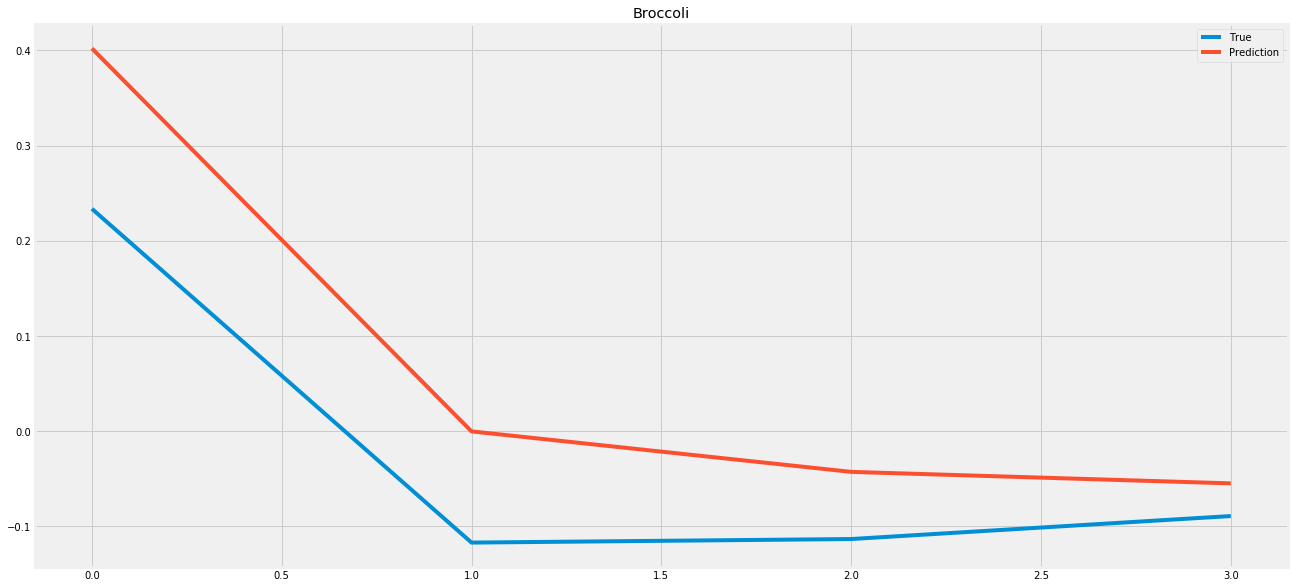

In [38]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Broccoli')
ax.legend()
plt.show()

In [39]:
carrot_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Carrot')]
carrot_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Carrot')].reset_index()
carrot_2015_new = carrot_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_carrot_2015 = carrot_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
carrot_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Carrot')].reset_index()
carrot_2016_new = carrot_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_carrot_2016 = carrot_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
carrot_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Carrot')].reset_index()
carrot_2017_new = carrot_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_carrot_2017 = carrot_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
carrot_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Carrot')].reset_index()
carrot_2018_new = carrot_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_carrot_2018 = carrot_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})


In [40]:
carr = ren_carrot_2015.join([ren_carrot_2016, ren_carrot_2017, ren_carrot_2018], how='outer')
trans_carr = carr.T 
carr_final = trans_carr.reset_index()
carr_data = carr_final.rename(columns={"index": "month", 0: "value"})
carr_data['mo'] = carr_data.index
carr_data.head()

,month,value,mo
0,m1,7804,0
1,m2,7198,1
2,m3,9948,2
3,m4,9790,3
4,m5,10273,4


In [41]:
carr_fin=carr_data[["mo", "value"]]
carr_fin.index = carr_fin.mo
carr_fin.drop('mo', axis=1, inplace=True)
carr_fin.to_csv('dset/carr.csv')


In [42]:
value = carr_fin['value'].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [43]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [44]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
lstm_4 (LSTM)                (None, 24)                3360      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=30)

Train on 33 samples, validate on 4 samples
Epoch 1/30
33/33 [==============================] - 2s 60ms/step - loss: 0.4011 - mean_squared_error: 0.4011 - val_loss: 0.1410 - val_mean_squared_error: 0.1410
Epoch 2/30
33/33 [==============================] - 0s 3ms/step - loss: 0.3607 - mean_squared_error: 0.3607 - val_loss: 0.1718 - val_mean_squared_error: 0.1718
Epoch 3/30
33/33 [==============================] - 0s 3ms/step - loss: 0.3247 - mean_squared_error: 0.3247 - val_loss: 0.2051 - val_mean_squared_error: 0.2051
Epoch 4/30
33/33 [==============================] - 0s 4ms/step - loss: 0.2926 - mean_squared_error: 0.2926 - val_loss: 0.2968 - val_mean_squared_error: 0.2968
Epoch 5/30
33/33 [==============================] - 0s 3ms/step - loss: 0.2597 - mean_squared_error: 0.2597 - val_loss: 0.3816 - val_mean_squared_error: 0.3816
Epoch 6/30
33/33 [==============================] - 0s 3ms/step - loss: 0.2483 - mean_squared_error: 0.2483 - val_loss: 0.4457 - val_mean_squared_error: 0.4

In [46]:
model.save("carr_model_trained.h5")

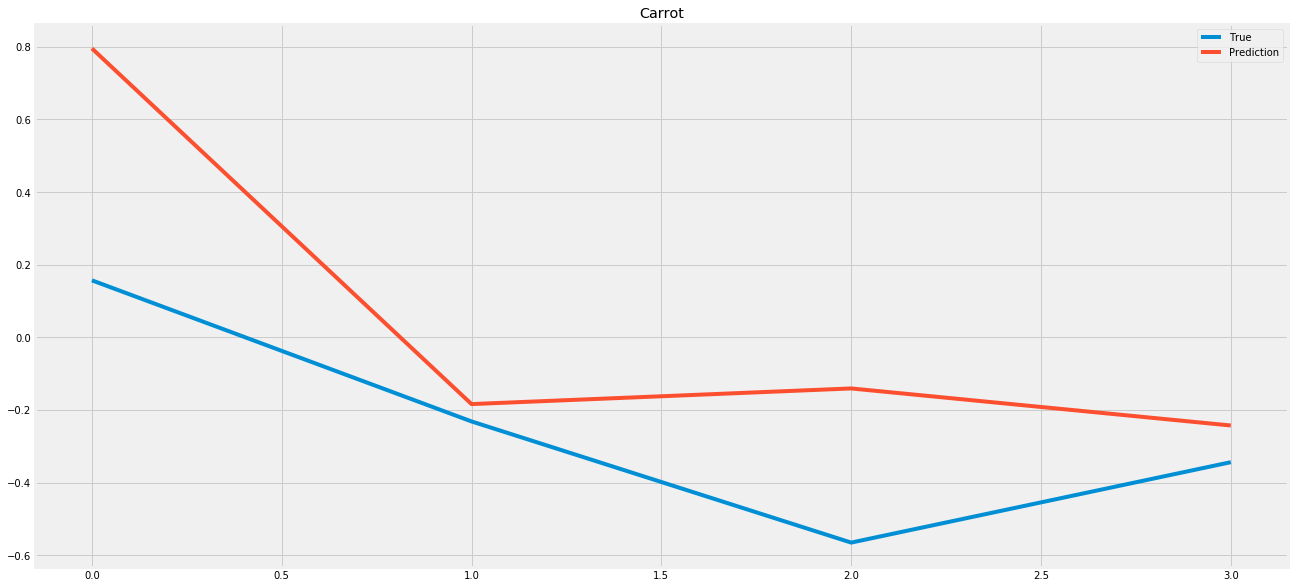

In [47]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Carrot')
ax.legend()
plt.show()

In [48]:
onion_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Onion')]
onn_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Onion')].reset_index()
onn_2015_new = onn_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_onn_2015 = onn_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
onn_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
onn_2016_new = onn_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_onn_2016 = onn_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
onn_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
onn_2017_new = onn_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_onn_2017 = onn_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
onn_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
onn_2018_new = onn_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_onn_2018 = onn_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
onn = ren_onn_2015.join([ren_onn_2016, ren_onn_2017, ren_onn_2018], how='outer')


In [49]:
onn = ren_onn_2015.join([ren_onn_2016, ren_onn_2017, ren_onn_2018], how='outer')
trans_onn = broc.T 
onn_final = trans_onn.reset_index()
onn_data = onn_final.rename(columns={"index": "month", 0: "value"})
onn_data['mo'] = onn_data.index


In [50]:

# #creating dataframe
# onn_dt = onn_data.sort_index(ascending=True, axis=0)

# new_onn_dt = pd.DataFrame(index=range(0,len(onn_dt)),columns=['mo', 'value'])
# for i in range(0,len(onn_dt)):
#     new_onn_dt['mo'][i] = new_onn_dt['mo'][i]
#     new_onn_dt['value'][i] = new_onn_dt['value'][i]

#     #setting index
# new_onn_dt.index = new_onn_dt.mo
# new_onn_dt.drop('mo', axis=1, inplace=True)
# new_onn_dt
onn_fin=onn_data[["mo", "value"]]

In [51]:
onn_fin.index = onn_fin.mo
onn_fin.drop('mo', axis=1, inplace=True)
onn_fin.head()
onn_fin.to_csv('dset/onn.csv')

In [52]:
value = onn_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [53]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [54]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
lstm_6 (LSTM)                (None, 24)                3360      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=30)

Train on 33 samples, validate on 4 samples
Epoch 1/30
33/33 [==============================] - 2s 69ms/step - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 2/30
33/33 [==============================] - 0s 5ms/step - loss: 0.0593 - mean_squared_error: 0.0593 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 3/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 4/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0532 - mean_squared_error: 0.0532 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 5/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0498 - mean_squared_error: 0.0498 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 6/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0052 - val_mean_squared_error: 0.0

In [56]:
model.save("onn_model_trained.h5")

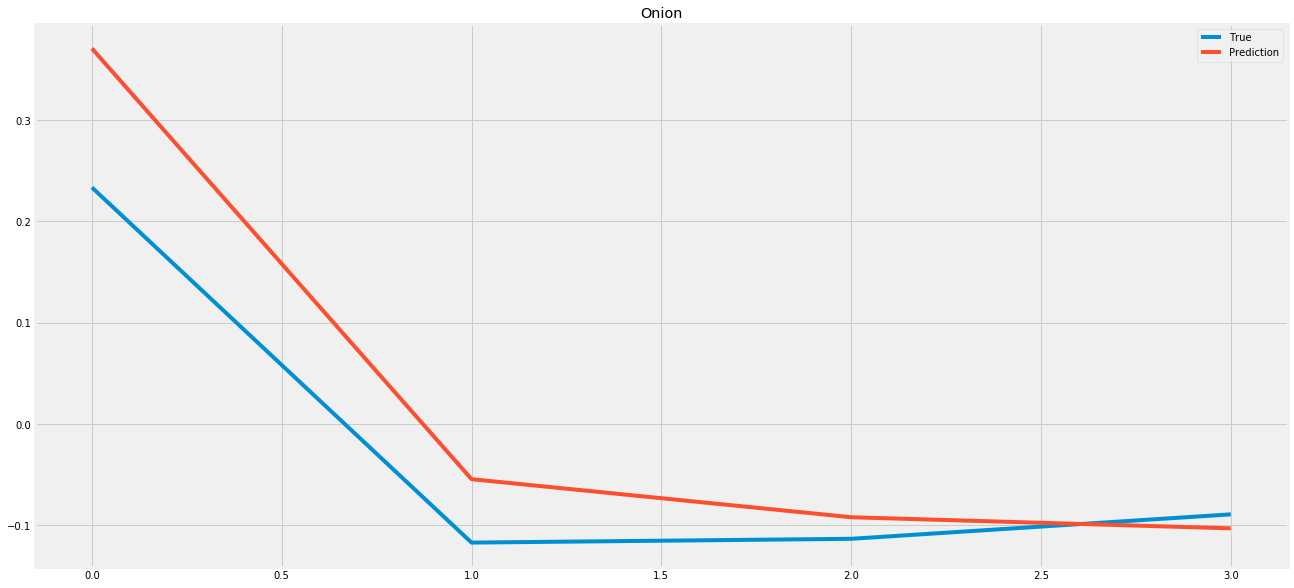

In [57]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Onion')
ax.legend()
plt.show()

In [58]:
pepper_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Pepper')]
pepp_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Pepper')].reset_index()
pepp_2015_new = pepp_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pepp_2015 = pepp_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
pepp_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
pepp_2016_new = pepp_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pepp_2016 = pepp_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
pepp_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
pepp_2017_new = pepp_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pepp_2017 = pepp_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
pepp_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
pepp_2018_new = pepp_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pepp_2018 = pepp_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
pepp = ren_pepp_2015.join([ren_pepp_2016, ren_pepp_2017, ren_pepp_2018], how='outer')


In [59]:

trans_pepp = pepp.T 
pepp_final = trans_pepp.reset_index()
pepp_data = pepp_final.rename(columns={"index": "month", 0: "value"})
pepp_data['mo'] = pepp_data.index
pepp_fin=pepp_data[["mo", "value"]]
pepp_fin.index = pepp_fin.mo
pepp_fin.drop('mo', axis=1, inplace=True)
pepp_fin.to_csv('dset/pepp.csv')


In [60]:
value = pepp_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [61]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [62]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
lstm_8 (LSTM)                (None, 24)                3360      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=30)

Train on 33 samples, validate on 4 samples
Epoch 1/30
33/33 [==============================] - 3s 87ms/step - loss: 2.7218 - mean_squared_error: 2.7218 - val_loss: 0.1286 - val_mean_squared_error: 0.1286
Epoch 2/30
33/33 [==============================] - 0s 3ms/step - loss: 2.5330 - mean_squared_error: 2.5330 - val_loss: 0.1099 - val_mean_squared_error: 0.1099
Epoch 3/30
33/33 [==============================] - 0s 3ms/step - loss: 2.3390 - mean_squared_error: 2.3390 - val_loss: 0.0856 - val_mean_squared_error: 0.0856
Epoch 4/30
33/33 [==============================] - 0s 3ms/step - loss: 2.1108 - mean_squared_error: 2.1108 - val_loss: 0.0650 - val_mean_squared_error: 0.0650
Epoch 5/30
33/33 [==============================] - 0s 3ms/step - loss: 1.8858 - mean_squared_error: 1.8858 - val_loss: 0.0441 - val_mean_squared_error: 0.0441
Epoch 6/30
33/33 [==============================] - 0s 3ms/step - loss: 1.6355 - mean_squared_error: 1.6355 - val_loss: 0.0361 - val_mean_squared_error: 0.0

In [64]:
model.save("pepp_model_trained.h5")

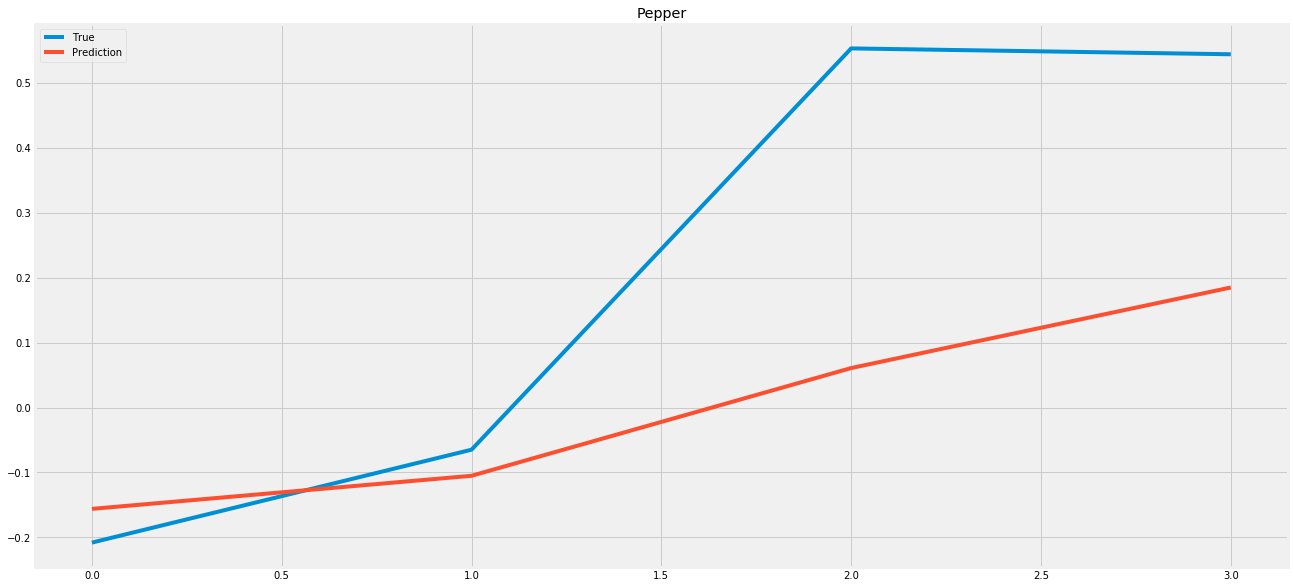

In [65]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Pepper')
ax.legend()
plt.show()

In [66]:
potato_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')]
pot_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
pot_2015_new = pot_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pot_2015 = pot_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
pot_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
pot_2016_new = pot_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pot_2016 = pot_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
pot_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
pot_2017_new = pot_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pot_2017 = pot_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
pot_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
pot_2018_new = pot_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pot_2018 = pot_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
pot = ren_pot_2015.join([ren_pot_2016, ren_pot_2017, ren_pot_2018], how='outer')


In [67]:
trans_pot = pot.T 
pot_final = trans_pot.reset_index()
pot_data = pot_final.rename(columns={"index": "month", 0: "value"})
pot_data['mo'] = pot_data.index
pot_fin=pot_data[["mo", "value"]]
pot_fin.index = pot_fin.mo
pot_fin.drop('mo', axis=1, inplace=True)
pot_fin.to_csv('dset/pot.csv')


In [68]:
value = pot_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [69]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [70]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
lstm_10 (LSTM)               (None, 24)                3360      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=30)

Train on 33 samples, validate on 4 samples
Epoch 1/30
33/33 [==============================] - 3s 89ms/step - loss: 0.1190 - mean_squared_error: 0.1190 - val_loss: 0.1625 - val_mean_squared_error: 0.1625
Epoch 2/30
33/33 [==============================] - 0s 3ms/step - loss: 0.1116 - mean_squared_error: 0.1116 - val_loss: 0.1560 - val_mean_squared_error: 0.1560
Epoch 3/30
33/33 [==============================] - 0s 3ms/step - loss: 0.1066 - mean_squared_error: 0.1066 - val_loss: 0.1496 - val_mean_squared_error: 0.1496
Epoch 4/30
33/33 [==============================] - 0s 3ms/step - loss: 0.1000 - mean_squared_error: 0.1000 - val_loss: 0.1404 - val_mean_squared_error: 0.1404
Epoch 5/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.1299 - val_mean_squared_error: 0.1299
Epoch 6/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0922 - mean_squared_error: 0.0922 - val_loss: 0.1176 - val_mean_squared_error: 0.1

In [72]:
model.save("pop_model_trained.h5")

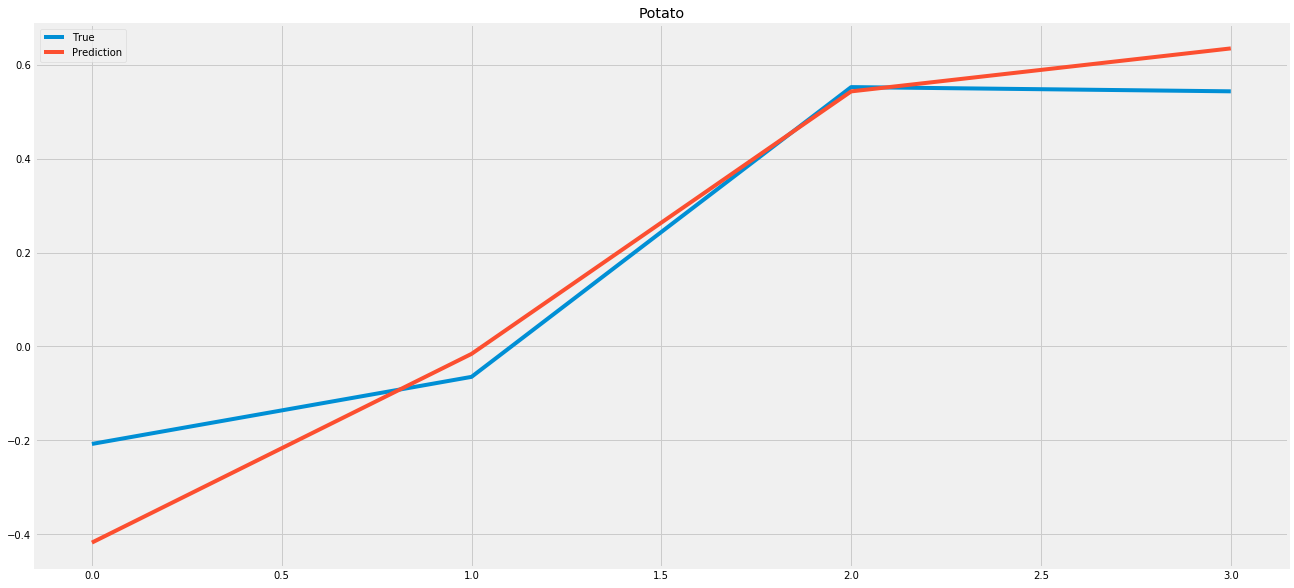

In [73]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Potato')
ax.legend()
plt.show()

In [74]:
apple_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Apple')]
app_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
app_2015_new = app_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_app_2015 = app_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
app_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
app_2016_new = app_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_app_2016 = app_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
app_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
app_2017_new = app_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_app_2017 = app_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
app_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
app_2018_new = app_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_app_2018 = app_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
app = ren_app_2015.join([ren_app_2016, ren_app_2017, ren_app_2018], how='outer')


In [75]:
trans_app = app.T 
app_final = trans_app.reset_index()
app_data = app_final.rename(columns={"index": "month", 0: "value"})
app_data['mo'] = app_data.index
app_fin=app_data[["mo", "value"]]
app_fin.index = app_fin.mo
app_fin.drop('mo', axis=1, inplace=True)
app_fin.to_csv('dset/app.csv')

In [76]:
value = app_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [77]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [78]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 10, 10)            480       
_________________________________________________________________
lstm_12 (LSTM)               (None, 24)                3360      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=30)

Train on 33 samples, validate on 4 samples
Epoch 1/30
33/33 [==============================] - 3s 95ms/step - loss: 0.1021 - mean_squared_error: 0.1021 - val_loss: 0.1459 - val_mean_squared_error: 0.1459
Epoch 2/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0993 - mean_squared_error: 0.0993 - val_loss: 0.1413 - val_mean_squared_error: 0.1413
Epoch 3/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0951 - mean_squared_error: 0.0951 - val_loss: 0.1361 - val_mean_squared_error: 0.1361
Epoch 4/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0922 - mean_squared_error: 0.0922 - val_loss: 0.1248 - val_mean_squared_error: 0.1248
Epoch 5/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0883 - mean_squared_error: 0.0883 - val_loss: 0.1198 - val_mean_squared_error: 0.1198
Epoch 6/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0847 - mean_squared_error: 0.0847 - val_loss: 0.1176 - val_mean_squared_error: 0.1

In [80]:
model.save("app_model_trained.h5")

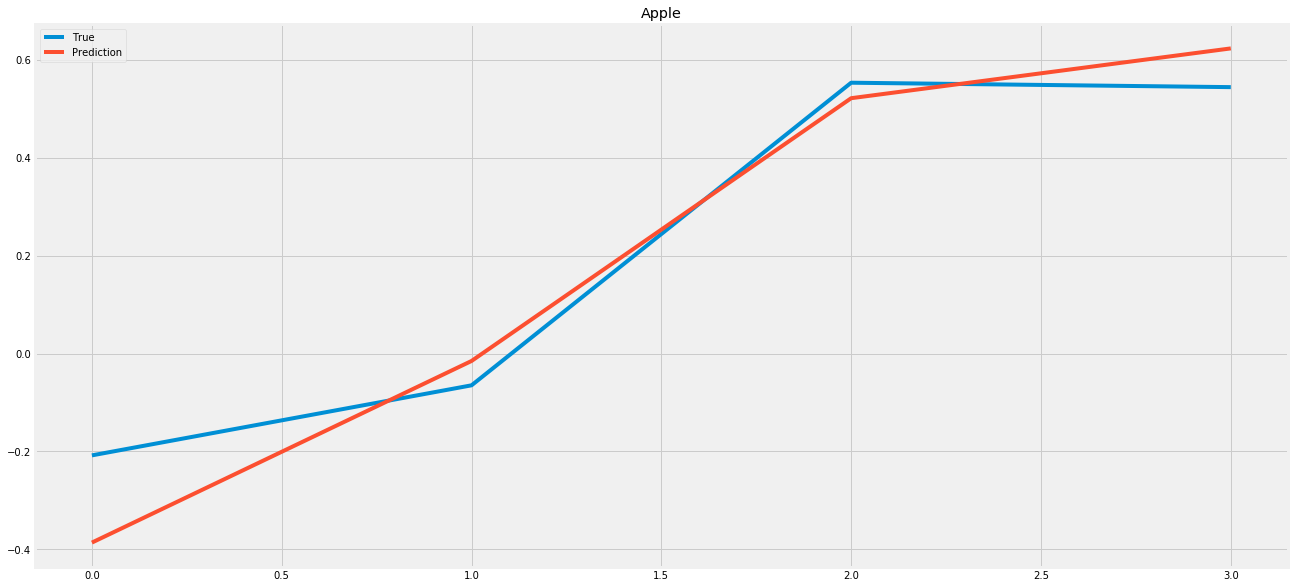

In [81]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Apple')
ax.legend()
plt.show()

In [82]:
grapes_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Grapes')]
grp_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
grp_2015_new = grp_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_grp_2015 = grp_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
grp_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
grp_2016_new = grp_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_grp_2016 = grp_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
grp_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
grp_2017_new = grp_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_grp_2017 = grp_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
grp_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
grp_2018_new = grp_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_grp_2018 = grp_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
grp = ren_grp_2015.join([ren_grp_2016, ren_grp_2017, ren_grp_2018], how='outer')


In [83]:
trans_grp = grp.T 
grp_final = trans_grp.reset_index()
grp_data = grp_final.rename(columns={"index": "month", 0: "value"})
grp_data['mo'] = grp_data.index
grp_fin=grp_data[["mo", "value"]]
grp_fin.index = grp_fin.mo
grp_fin.drop('mo', axis=1, inplace=True)
grp_fin.to_csv('dset/grp.csv')

In [84]:
value = grp_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [85]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [86]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 10, 10)            480       
_________________________________________________________________
lstm_14 (LSTM)               (None, 24)                3360      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=30)

Train on 33 samples, validate on 4 samples
Epoch 1/30
33/33 [==============================] - 3s 105ms/step - loss: 0.1048 - mean_squared_error: 0.1048 - val_loss: 0.1481 - val_mean_squared_error: 0.1481
Epoch 2/30
33/33 [==============================] - 0s 3ms/step - loss: 0.1004 - mean_squared_error: 0.1004 - val_loss: 0.1462 - val_mean_squared_error: 0.1462
Epoch 3/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0963 - mean_squared_error: 0.0963 - val_loss: 0.1350 - val_mean_squared_error: 0.1350
Epoch 4/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0931 - mean_squared_error: 0.0931 - val_loss: 0.1321 - val_mean_squared_error: 0.1321
Epoch 5/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0912 - mean_squared_error: 0.0912 - val_loss: 0.1313 - val_mean_squared_error: 0.1313
Epoch 6/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0886 - mean_squared_error: 0.0886 - val_loss: 0.1271 - val_mean_squared_error: 0.

In [88]:
model.save("grp_model_trained.h5")

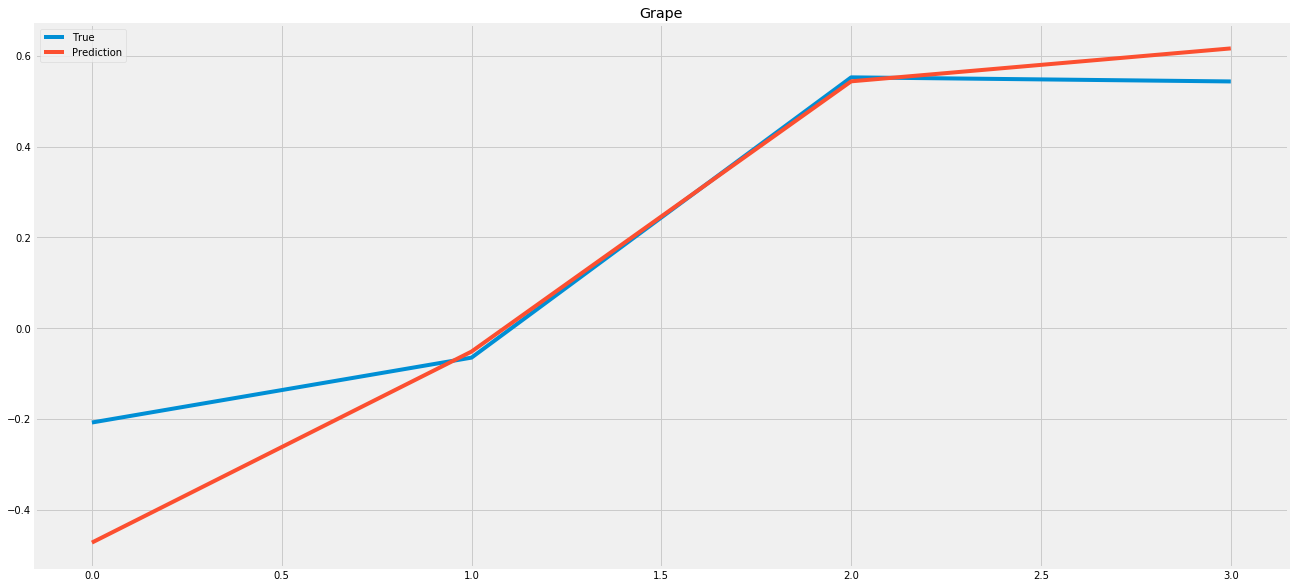

In [89]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Grape')
ax.legend()
plt.show()

In [90]:
orange_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Orange')]
orn_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
orn_2015_new = orn_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_orn_2015 = orn_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
orn_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
orn_2016_new = orn_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_orn_2016 = orn_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
orn_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
orn_2017_new = orn_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_orn_2017 = orn_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
orn_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
orn_2018_new = orn_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_orn_2018 = orn_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
orn = ren_orn_2015.join([ren_orn_2016, ren_orn_2017, ren_orn_2018], how='outer')


In [91]:
trans_orn = orn.T 
orn_final = trans_orn.reset_index()
orn_data = orn_final.rename(columns={"index": "month", 0: "value"})
orn_data['mo'] = orn_data.index
orn_fin=orn_data[["mo", "value"]]
orn_fin.index = orn_fin.mo
orn_fin.drop('mo', axis=1, inplace=True)
orn_fin.to_csv('dset/orn.csv')

In [92]:
value = orn_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [93]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [94]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 10, 10)            480       
_________________________________________________________________
lstm_16 (LSTM)               (None, 24)                3360      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [95]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=30)

Train on 33 samples, validate on 4 samples
Epoch 1/30
33/33 [==============================] - 4s 110ms/step - loss: 0.1076 - mean_squared_error: 0.1076 - val_loss: 0.1477 - val_mean_squared_error: 0.1477
Epoch 2/30
33/33 [==============================] - 0s 3ms/step - loss: 0.1017 - mean_squared_error: 0.1017 - val_loss: 0.1427 - val_mean_squared_error: 0.1427
Epoch 3/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0992 - mean_squared_error: 0.0992 - val_loss: 0.1311 - val_mean_squared_error: 0.1311
Epoch 4/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.1199 - val_mean_squared_error: 0.1199
Epoch 5/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0930 - mean_squared_error: 0.0930 - val_loss: 0.1204 - val_mean_squared_error: 0.1204
Epoch 6/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.1252 - val_mean_squared_error: 0.

In [96]:
model.save("orn_model_trained.h5")

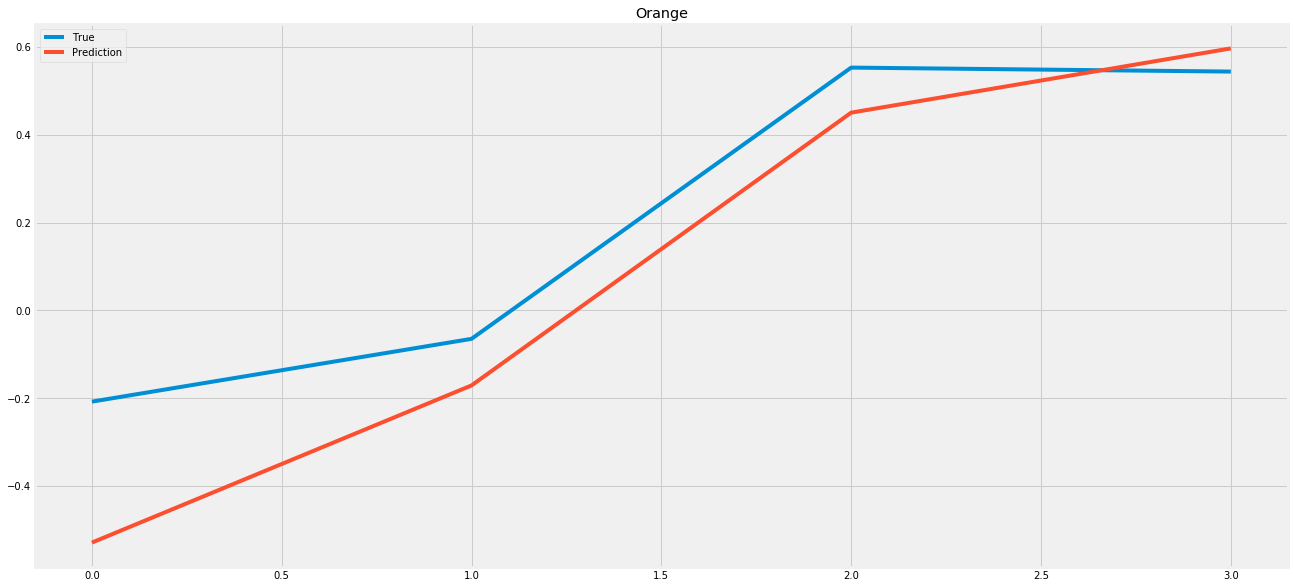

In [97]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Orange')
ax.legend()
plt.show()

In [98]:
pears_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Pears')]
pr_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
pr_2015_new = pr_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pr_2015 = pr_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
pr_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
pr_2016_new = pr_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pr_2016 = pr_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
pr_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
pr_2017_new = pr_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pr_2017 = pr_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
pr_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
pr_2018_new = pr_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pr_2018 = pr_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
pr = ren_pr_2015.join([ren_pr_2016, ren_pr_2017, ren_pr_2018], how='outer')


In [99]:
trans_pr = pr.T 
pr_final = trans_pr.reset_index()
pr_data = pr_final.rename(columns={"index": "month", 0: "value"})
pr_data['mo'] = pr_data.index
pr_fin=pr_data[["mo", "value"]]
pr_fin.index = pr_fin.mo
pr_fin.drop('mo', axis=1, inplace=True)
pr_fin.to_csv('dset/pr.csv')

In [100]:
value = pr_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [101]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [102]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse',metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 10, 10)            480       
_________________________________________________________________
lstm_18 (LSTM)               (None, 24)                3360      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [103]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=30)

Train on 33 samples, validate on 4 samples
Epoch 1/30
33/33 [==============================] - 4s 123ms/step - loss: 0.1213 - mean_squared_error: 0.1213 - val_loss: 0.1670 - val_mean_squared_error: 0.1670
Epoch 2/30
33/33 [==============================] - 0s 3ms/step - loss: 0.1130 - mean_squared_error: 0.1130 - val_loss: 0.1625 - val_mean_squared_error: 0.1625
Epoch 3/30
33/33 [==============================] - 0s 3ms/step - loss: 0.1081 - mean_squared_error: 0.1081 - val_loss: 0.1527 - val_mean_squared_error: 0.1527
Epoch 4/30
33/33 [==============================] - 0s 3ms/step - loss: 0.1013 - mean_squared_error: 0.1013 - val_loss: 0.1464 - val_mean_squared_error: 0.1464
Epoch 5/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0985 - mean_squared_error: 0.0985 - val_loss: 0.1400 - val_mean_squared_error: 0.1400
Epoch 6/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.1409 - val_mean_squared_error: 0.

In [104]:
model.save("pr_model_trained.h5")

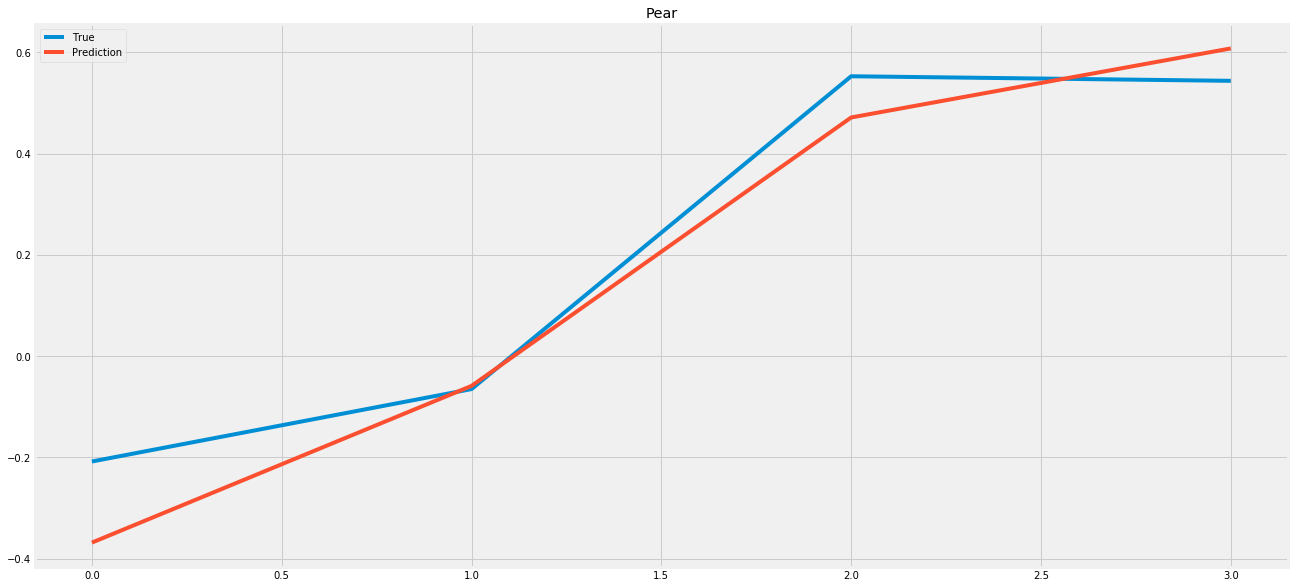

In [105]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Pear')
ax.legend()
plt.show()

In [106]:
strawberries_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Strawberries')]
str_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
str_2015_new = str_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_str_2015 = str_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
str_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
str_2016_new = str_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_str_2016 = str_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
str_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
str_2017_new = str_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_str_2017 = str_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
str_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
str_2018_new = str_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_str_2018 = str_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
strw = ren_str_2015.join([ren_str_2016, ren_str_2017, ren_str_2018], how='outer')

In [107]:
trans_str = strw.T 
str_final = trans_str.reset_index()
str_data = str_final.rename(columns={"index": "month", 0: "value"})
str_data['mo'] = str_data.index
str_fin=str_data[["mo", "value"]]
str_fin.index = str_fin.mo
str_fin.drop('mo', axis=1, inplace=True)
str_fin.to_csv('dset/str.csv')

In [108]:
value = str_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [109]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [110]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', metrics=['mean_squared_error'], optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 10, 10)            480       
_________________________________________________________________
lstm_20 (LSTM)               (None, 24)                3360      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [111]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=30)

Train on 33 samples, validate on 4 samples
Epoch 1/30
33/33 [==============================] - 5s 146ms/step - loss: 0.1201 - mean_squared_error: 0.1201 - val_loss: 0.1631 - val_mean_squared_error: 0.1631
Epoch 2/30
33/33 [==============================] - 0s 3ms/step - loss: 0.1125 - mean_squared_error: 0.1125 - val_loss: 0.1553 - val_mean_squared_error: 0.1553
Epoch 3/30
33/33 [==============================] - 0s 3ms/step - loss: 0.1069 - mean_squared_error: 0.1069 - val_loss: 0.1418 - val_mean_squared_error: 0.1418
Epoch 4/30
33/33 [==============================] - 0s 3ms/step - loss: 0.1019 - mean_squared_error: 0.1019 - val_loss: 0.1328 - val_mean_squared_error: 0.1328
Epoch 5/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0974 - mean_squared_error: 0.0974 - val_loss: 0.1208 - val_mean_squared_error: 0.1208
Epoch 6/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.1249 - val_mean_squared_error: 0.

In [112]:
model.save("str_model_trained.h5")

In [113]:
# model.compile(optimizer='adam', loss='mse', metrics=['mse', 'accuracy'])
# model.evaluate()

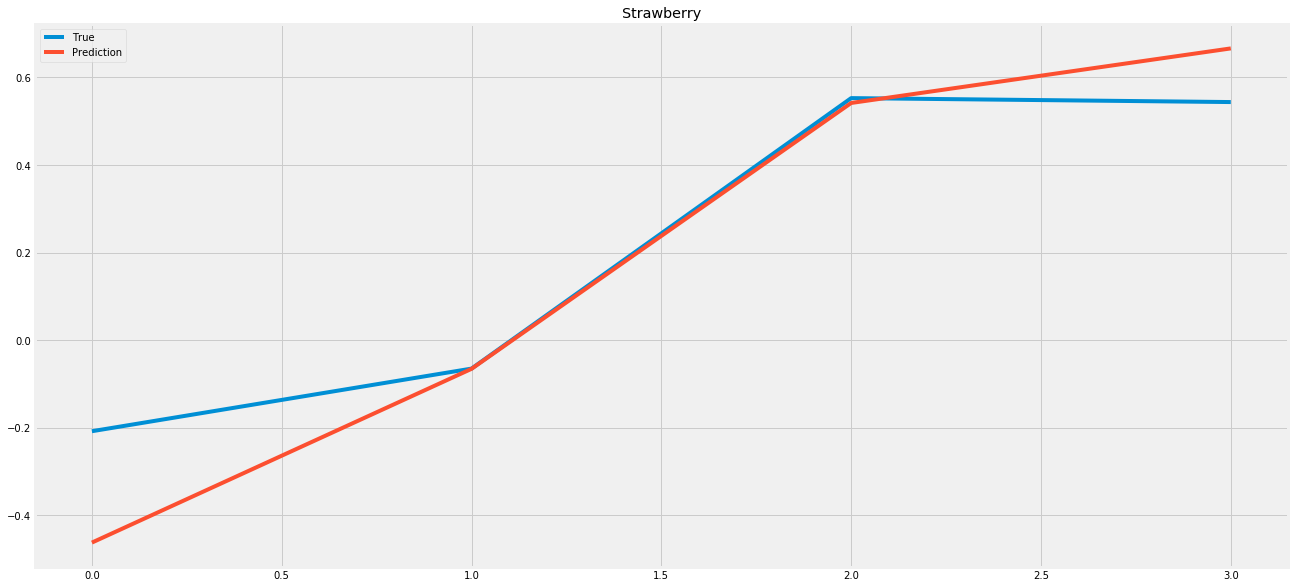

In [114]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Strawberry')
ax.legend()
plt.show()